
# Imputing Missing Values

## Description

Proper handling of missing data is crucial to derive reliable conclusions from an analysis, particularly when the underlying process is not completely random. The following three examples illustrate these critical cases:

* A survey-based earnings series may have missing values because high-income respondents do not want to reveal their earnings. 
* Patients may be more likely to opt out of undertaking a medical treatment when the treatment causes discomfort. 
* A blood pressure data series may have missing values for young patients who have no cardiovascular diseases. 

This analysis focuses on one of these critical cases illustrated by the blood pressure example above. This case is called "missingness at random", a confusing name as it does not sound much different from the "missingness completely at random" case. But, they are different. When data are missing at random, the probability of missingness depends on the available information. The following analysis examines if a random regression approach can be used to impute the missing data in these cases (for a comprehensive treatment of the subject, please refer to Gelman and Hill).  

The analysis uses an unconditional income convergence model for its simplicity. In this model, growth in a country's incomes is explained by the country's initial income level, adjusted for cross-country price differentials. The expectation is that countries that start off from a relatively low income level grow faster and catch up with the rest. The "missingness at random" mechanism is implemented by setting half of the values in the independent variable, PPP adjusted per capita GDP series, to missing .

## Data Preparation



The data used in the analysis are from the World Development Indicators database, downloaded through the API. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy.stats import gmean
import numpy as np
import statsmodels.api as sm

In [2]:
url = 'http://api.worldbank.org/v2/country/all/indicator'
indicator_list = ['NY.GDP.PCAP.KD.ZG',
                  'NY.GDP.PCAP.PP.CD']
parameters = {'date': '1989:2018',
              'footnote': 'n',
              'format': 'json',
              'per_page': 7920}
results_list = []
for indicator in indicator_list:
    results = requests.get(f'{url}/{indicator}', params = parameters)
    if results.status_code == 200:
        results_list.append(results.json())
    else:
        print('Failed request')

In [135]:
%run data_prep.py

In [4]:
df = flatten_wb_api_response(results_list)

To limit the analysis the countries and exclude the aggregates, the UN country code list is used as a filter. The period of analysis is 1994-2018.

In [5]:
df = clean_data(df)

In [6]:
df.head()

indicator,country_iso3_code,country,year,pc_GDP_growth,pc_GDP_PPP
5,ABW,Aruba,1994,2.284430,27714.716606
6,ABW,Aruba,1995,-2.079505,27707.433894
7,ABW,Aruba,1996,-2.311930,27562.459828
8,ABW,Aruba,1997,4.226981,29222.894599
9,ABW,Aruba,1998,-0.141877,29509.877023


The initial per capita GDP (PPP adjusted) is a 3-year (1994-96) average.

In [8]:
pc_GDP_PPP_df = df.loc[(df.year >= 1994) & (df.year <= 1996)]
pc_GDP_PPP_df = pc_GDP_PPP_df.groupby(['country_iso3_code', 'country']).mean()[['pc_GDP_PPP']]

Geometric average of the real GDP growth rates is computed for each country and for the period 1995-2018.

In [9]:
pc_GDP_growth_df = df.loc[(df.year >= 1995) & (df.year <= 2018)]

In [10]:
pc_GDP_growth_df['pc_GDP_growth'] = (pc_GDP_growth_df.pc_GDP_growth + 100) / 100

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
pc_GDP_growth_df = pc_GDP_growth_df.groupby(['country_iso3_code', 'country'])

In [12]:
pc_GDP_growth_df = pc_GDP_growth_df.pc_GDP_growth.apply(gmean)

In [13]:
convergence_df = pc_GDP_PPP_df.merge(pc_GDP_growth_df, left_index = True, right_index = True)

In [14]:
convergence_df['pc_GDP_PPP'] = np.log(convergence_df.pc_GDP_PPP)

In [15]:
convergence_df['pc_GDP_growth'] = (convergence_df.pc_GDP_growth - 1) * 100

In [16]:
convergence_df.head()

,,pc_GDP_PPP,pc_GDP_growth
country_iso3_code,country,,
ABW,Aruba,10.227798,-0.467633
AGO,Angola,7.878085,2.644252
ALB,Albania,7.880279,5.231749
ARE,United Arab Emirates,11.401524,-1.719834
ARG,Argentina,9.234410,0.958335


In [17]:
convergence_df.describe()

,pc_GDP_PPP,pc_GDP_growth
count,180.000000,180.000000
mean,8.453381,2.323305
std,1.212102,1.948434
min,5.821235,-1.719834
25%,7.500111,1.170496
50%,8.503141,1.963249
75%,9.355601,3.145496
max,11.401524,11.261777


## Analysis

In [136]:
convergence_df = add_weights(convergence_df)

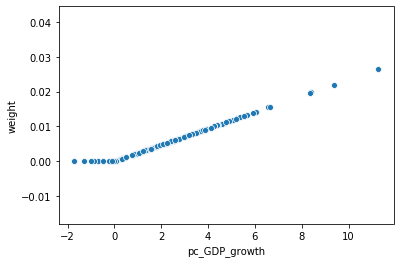

In [137]:
ax1 = sns.scatterplot(x = 'pc_GDP_growth', y = 'weight', data = convergence_df)

In [138]:
convergence_df.weight.sum()

1.0

### Creating missing values

In [139]:
np.random.seed(seed = 12345)

In [140]:
na_df = convergence_df.copy()
na_df.loc[na_df.sample(frac = 0.5, replace = False, weights = 'weight').index, 'pc_GDP_PPP'] = np.nan 

In [141]:
na_df.head()

,,pc_GDP_PPP,pc_GDP_growth,weight
country_iso3_code,country,,,
ABW,Aruba,10.227798,-0.467633,0.000000
AGO,Angola,7.878085,2.644252,0.006213
ALB,Albania,NaN,5.231749,0.012293
ARE,United Arab Emirates,11.401524,-1.719834,0.000000
ARG,Argentina,9.234410,0.958335,0.002252


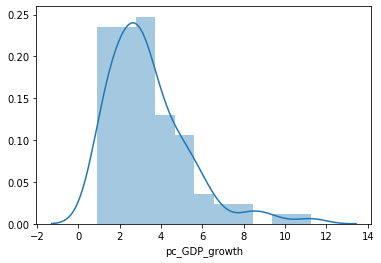

In [142]:
ax1 = sns.distplot(na_df.loc[na_df.pc_GDP_PPP.isna(), 'pc_GDP_growth'])

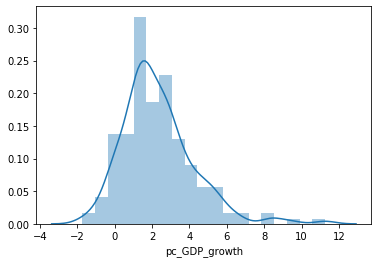

In [143]:
ax1 = sns.distplot(na_df['pc_GDP_growth'])

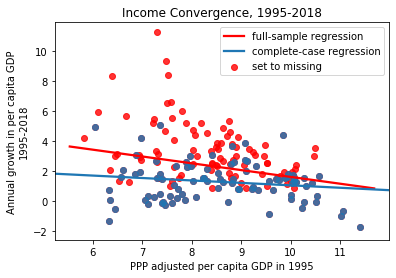

In [144]:
ax1 = sns.regplot(x = 'pc_GDP_PPP', y = 'pc_GDP_growth', data = convergence_df, ci = None, color = 'r')
sns.regplot(x = 'pc_GDP_PPP', y = 'pc_GDP_growth', data = na_df, ci = None, ax = ax1)
ax1.set_xlabel('PPP adjusted per capita GDP in 1995')
ax1.set_ylabel('Annual growth in per capita GDP\n1995-2018')
ax1.set_title('Income Convergence, 1995-2018')
ax1.legend(['full-sample regression', 'complete-case regression', 'set to missing'])
plt.show()

In [145]:
model = sm.OLS.from_formula('pc_GDP_PPP ~ pc_GDP_growth', na_df, missing = 'drop')
rslts = model.fit()
beta0 = rslts.params['Intercept']
beta1 = rslts.params['pc_GDP_growth']
std0 = rslts.bse['Intercept']
std1 = rslts.bse['pc_GDP_growth']

In [146]:
imputed_df = na_df.copy()

In [147]:
for i in imputed_df.loc[imputed_df.pc_GDP_PPP.isna()].index:
    imputed_df.pc_GDP_PPP[i] = np.random.normal(loc = beta0, scale = std0, size = 1) + \
                               np.random.normal(loc = beta1, scale = std1, size = 1) * imputed_df.pc_GDP_growth[i]

In [148]:
imputed_df.head()

,,pc_GDP_PPP,pc_GDP_growth,weight
country_iso3_code,country,,,
ABW,Aruba,10.227798,-0.467633,0.000000
AGO,Angola,7.878085,2.644252,0.006213
ALB,Albania,7.327095,5.231749,0.012293
ARE,United Arab Emirates,11.401524,-1.719834,0.000000
ARG,Argentina,9.234410,0.958335,0.002252


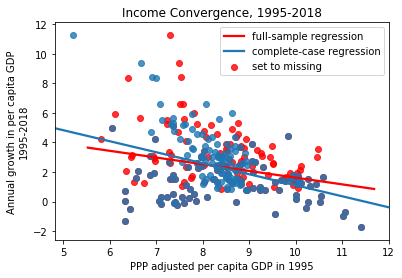

In [149]:
ax1 = sns.regplot(x = 'pc_GDP_PPP', y = 'pc_GDP_growth', data = convergence_df, ci = None, color = 'r')
sns.regplot(x = 'pc_GDP_PPP', y = 'pc_GDP_growth', data = imputed_df, ci = None, ax = ax1)
ax1.set_xlabel('PPP adjusted per capita GDP in 1995')
ax1.set_ylabel('Annual growth in per capita GDP\n1995-2018')
ax1.set_title('Income Convergence, 1995-2018')
ax1.legend(['full-sample regression', 'complete-case regression', 'set to missing'])
plt.show()

In [150]:
%run Analysis.py

In [151]:
na_df_list = simulate_na(convergence_df, N = 200)

In [152]:
na_df_list[0].head(20)

,,pc_GDP_PPP,pc_GDP_growth,weight
country_iso3_code,country,,,
ABW,Aruba,10.227798,-0.467633,0.000000
AGO,Angola,NaN,2.644252,0.006213
ALB,Albania,NaN,5.231749,0.012293
ARE,United Arab Emirates,11.401524,-1.719834,0.000000
ARG,Argentina,9.234410,0.958335,0.002252
ARM,Armenia,NaN,6.572087,0.015442
ATG,Antigua and Barbuda,NaN,0.983049,0.002310
AUS,Australia,NaN,1.791461,0.004209
AUT,Austria,10.068588,1.425074,0.003348


In [153]:
na_ols_rslts_dict = run_ols(na_df_list)

In [154]:
na_betas_df = get_betas(na_ols_rslts_dict, scope = 'complete case')

In [155]:
na_betas_df.groupby('type').mean()

,beta0,beta1,std0,std1
type,,,,
x_on_y,8.749691,-0.115491,0.191289,0.097711
y_on_x,2.584533,-0.139719,0.998049,0.114935


In [156]:
fs_ols_rslts_dict = run_ols([convergence_df])

In [157]:
fs_betas_df = get_betas(fs_ols_rslts_dict, scope = 'full sample')

In [158]:
fs_betas_df.head()

,scope,type,beta0,beta1,std0,std1
0,full sample,x_on_y,8.861620,-0.175715,0.135471,0.044729
1,full sample,y_on_x,6.161547,-0.454048,0.986977,0.115580


In [159]:
imputed_df_list = impute_na(na_df_list, na_betas_df.loc[na_betas_df.type == 'x_on_y'])

In [160]:
imputed_df_list[0].head(20)

,,pc_GDP_PPP,pc_GDP_growth,weight
country_iso3_code,country,,,
ABW,Aruba,10.227798,-0.467633,0.000000
AGO,Angola,8.821863,2.644252,0.006213
ALB,Albania,8.715951,5.231749,0.012293
ARE,United Arab Emirates,11.401524,-1.719834,0.000000
ARG,Argentina,9.234410,0.958335,0.002252
ARM,Armenia,10.135339,6.572087,0.015442
ATG,Antigua and Barbuda,8.523110,0.983049,0.002310
AUS,Australia,9.030481,1.791461,0.004209
AUT,Austria,10.068588,1.425074,0.003348


In [161]:
is_ols_rslts_dict = run_ols(imputed_df_list)
is_betas_df = get_betas(is_ols_rslts_dict, scope = 'imputed sample')
is_betas_df.groupby('type').mean()

,beta0,beta1,std0,std1
type,,,,
x_on_y,8.747686,-0.114333,0.110632,0.036528
y_on_x,6.034626,-0.439834,1.231865,0.144192


In [162]:
betas_df = fs_betas_df.append(na_betas_df, ignore_index = True)
betas_df = betas_df.append(is_betas_df, ignore_index = True)
betas_df = betas_df.reset_index()

In [163]:
betas_df.loc[betas_df.type == 'y_on_x'].groupby('scope').mean()[['beta1', 'std1']]

,beta1,std1
scope,,
complete case,-0.139719,0.114935
full sample,-0.454048,0.115580
imputed sample,-0.439834,0.144192
